In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet
from torchvision.transforms import v2
from matplotlib import pyplot as plt

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

#contour = load_contour().to(device)
#contour.shape

torch.Size([3, 386, 3, 64, 64])

In [2]:
T = 100
beta = torch.linspace(10e-4, 0.1, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(0.0054, device='cuda:0')

In [3]:
alpha_

tensor([0.9990, 0.9970, 0.9940, 0.9900, 0.9851, 0.9792, 0.9723, 0.9645, 0.9559,
        0.9463, 0.9359, 0.9247, 0.9126, 0.8999, 0.8864, 0.8722, 0.8574, 0.8419,
        0.8259, 0.8094, 0.7924, 0.7750, 0.7572, 0.7390, 0.7205, 0.7018, 0.6828,
        0.6637, 0.6445, 0.6251, 0.6057, 0.5864, 0.5670, 0.5477, 0.5286, 0.5095,
        0.4907, 0.4720, 0.4536, 0.4355, 0.4176, 0.4001, 0.3829, 0.3660, 0.3496,
        0.3335, 0.3178, 0.3026, 0.2877, 0.2733, 0.2594, 0.2459, 0.2329, 0.2203,
        0.2082, 0.1965, 0.1853, 0.1746, 0.1643, 0.1544, 0.1450, 0.1360, 0.1274,
        0.1193, 0.1115, 0.1042, 0.0972, 0.0906, 0.0843, 0.0784, 0.0729, 0.0676,
        0.0627, 0.0580, 0.0537, 0.0496, 0.0458, 0.0422, 0.0389, 0.0358, 0.0329,
        0.0302, 0.0277, 0.0253, 0.0232, 0.0212, 0.0194, 0.0177, 0.0161, 0.0146,
        0.0133, 0.0121, 0.0110, 0.0099, 0.0090, 0.0081, 0.0073, 0.0066, 0.0060,
        0.0054], device='cuda:0')

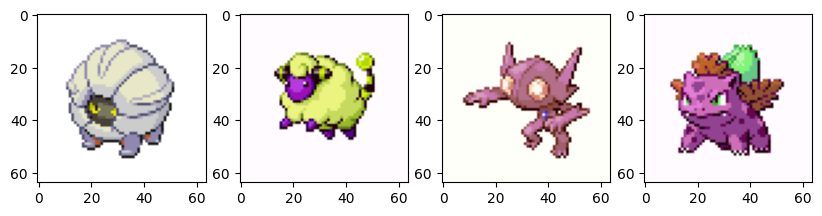

In [4]:
transform = v2.Compose([
    v2.ColorJitter(),
    v2.RandomChannelPermutation(),
    v2.RandomGrayscale(p = 0.1),
    #v2.GaussianBlur(kernel_size=9, sigma=(1,1))
])

source = randint(0, 2)
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
x0 = torch.stack([transform(x) for x in x0], dim=0)

fig, axes = plt.subplots(1, 4, figsize=(10, 10))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [5]:
model = UNet(3, 3).to(device)

@torch.no_grad
def generate_image():
    model.eval()

    #cont = contour[1, 151]
    x = torch.randn((3,64,64), device=device)

    for t in reversed(range(T)):
        tt = torch.tensor(t, device=device)

        z = torch.randn((3,64,64), device=device)

        #xn = torch.cat([x, cont], dim=0)
        e = model(x[None], tt)[0] * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])

        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])
        
    plot_image(x)
    plt.show()

    model.train()

  0%|          | 0/20001 [00:00<?, ?it/s]

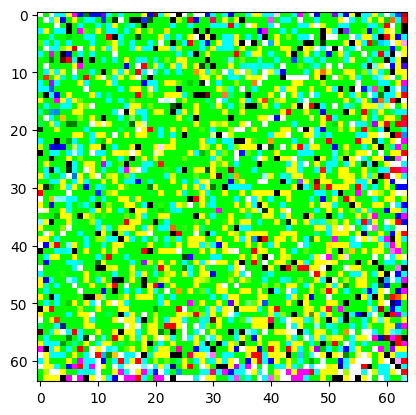

0.14752173:   2%|▏         | 499/20001 [00:38<24:44, 13.14it/s]

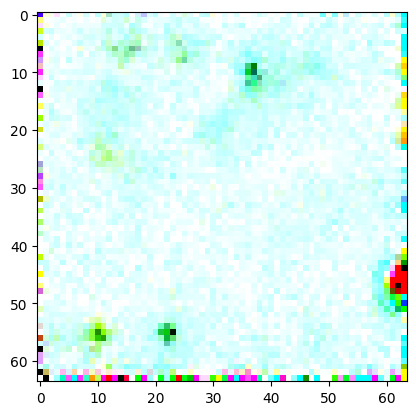

0.08896106:   5%|▍         | 999/20001 [01:17<24:11, 13.09it/s]

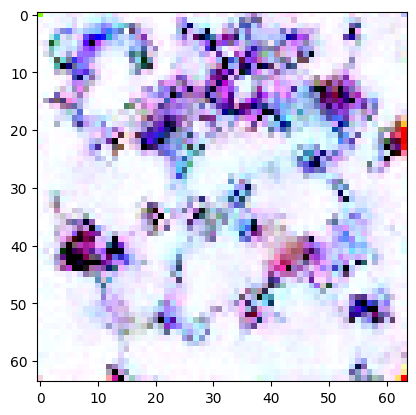

0.12255587:   7%|▋         | 1499/20001 [01:56<23:34, 13.08it/s]

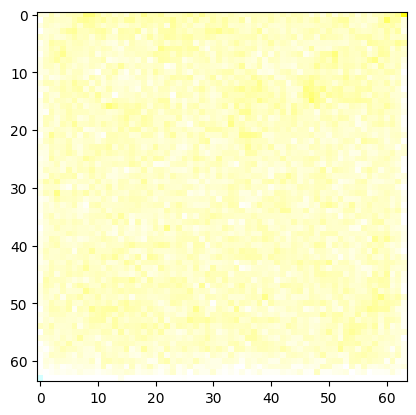

0.04260086:  10%|▉         | 1999/20001 [02:35<22:57, 13.07it/s]

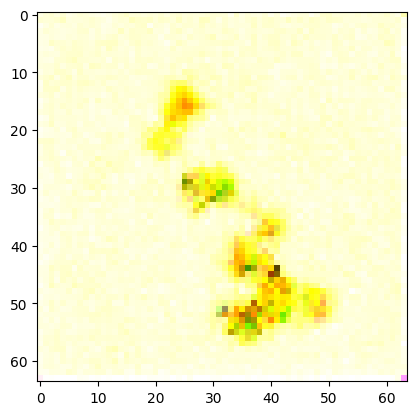

0.08765139:  12%|█▏        | 2499/20001 [03:14<22:15, 13.10it/s]

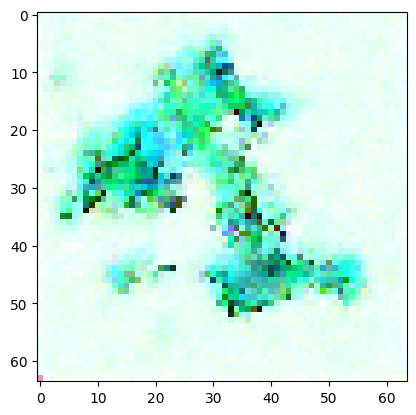

0.02992041:  15%|█▍        | 2999/20001 [03:52<21:35, 13.12it/s]

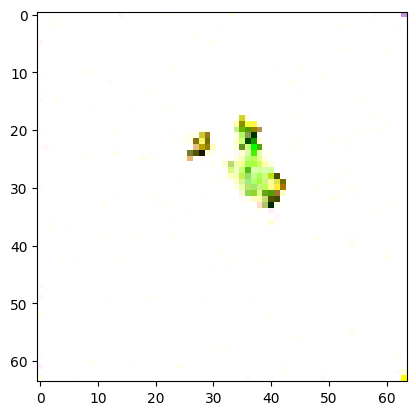

0.04801706:  17%|█▋        | 3499/20001 [04:31<20:59, 13.10it/s]

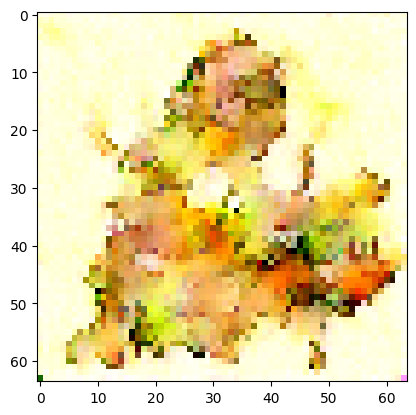

0.08807548:  20%|█▉        | 3999/20001 [05:10<20:18, 13.13it/s]

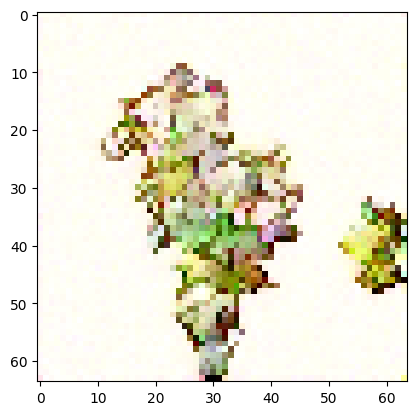

0.08592596:  22%|██▏       | 4499/20001 [05:49<19:41, 13.12it/s]

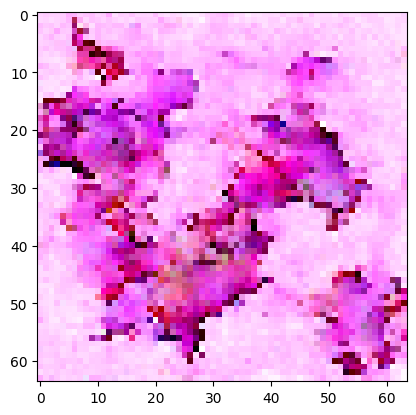

0.05596669:  25%|██▍       | 4999/20001 [06:27<19:03, 13.12it/s]

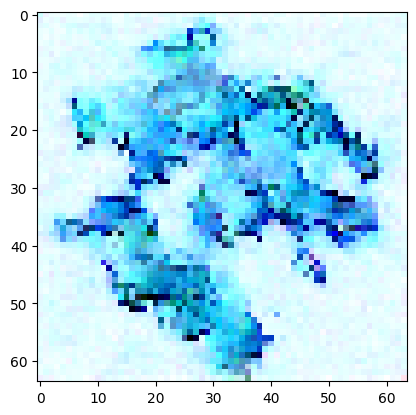

0.05312088:  27%|██▋       | 5499/20001 [07:06<18:26, 13.10it/s]

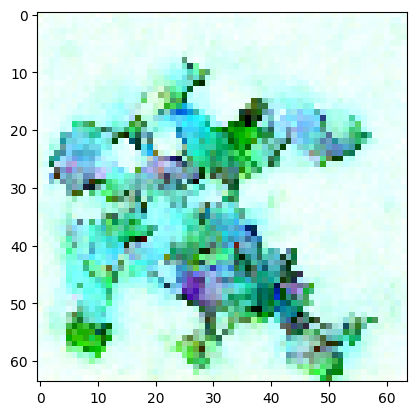

0.05802097:  30%|██▉       | 5999/20001 [07:45<17:47, 13.11it/s]

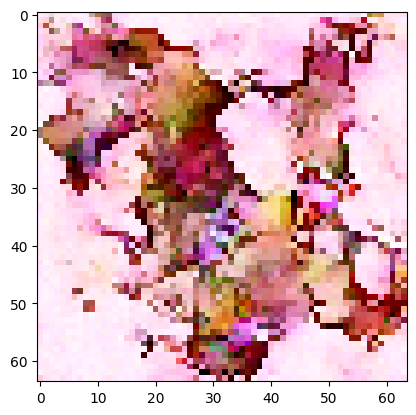

0.05779227:  32%|███▏      | 6499/20001 [08:24<17:11, 13.09it/s]

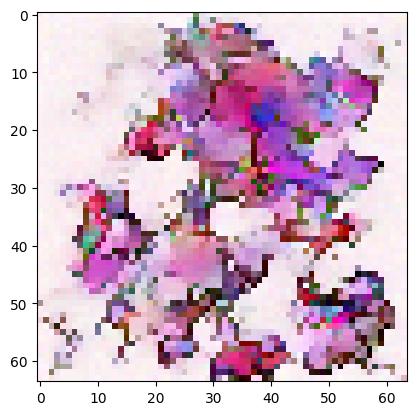

0.05781209:  35%|███▍      | 6999/20001 [09:03<16:33, 13.08it/s]

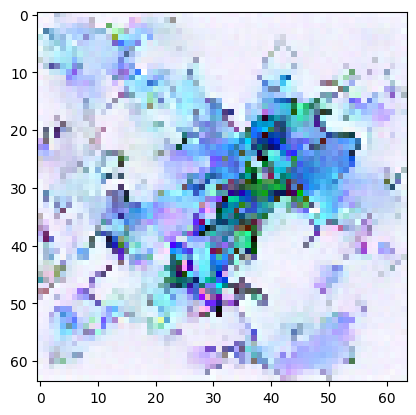

0.06438129:  37%|███▋      | 7499/20001 [09:41<15:54, 13.10it/s]

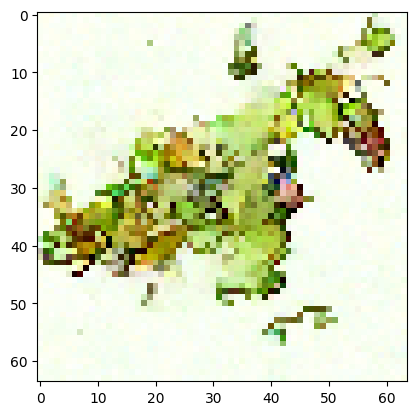

0.05891071:  40%|███▉      | 7999/20001 [10:20<15:16, 13.09it/s]

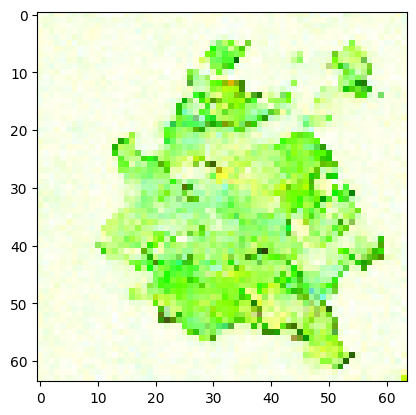

0.04924180:  42%|████▏     | 8499/20001 [10:59<14:37, 13.11it/s]

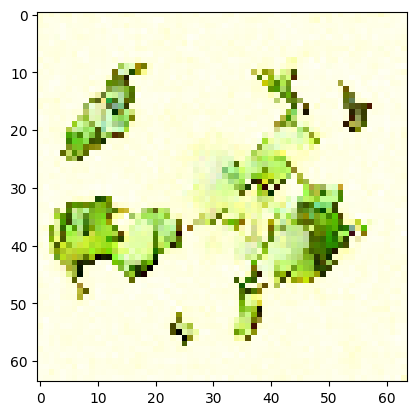

0.06484415:  45%|████▍     | 8999/20001 [11:38<13:59, 13.10it/s]

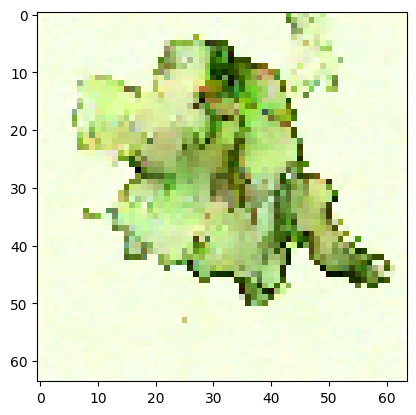

0.02979208:  47%|████▋     | 9499/20001 [12:17<13:21, 13.10it/s]

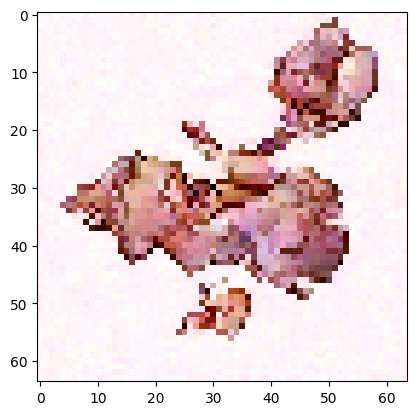

0.05205282:  50%|████▉     | 9999/20001 [12:55<12:42, 13.11it/s]

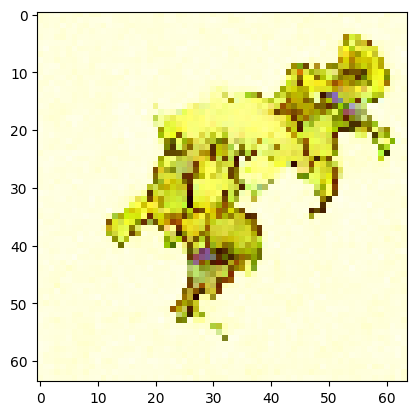

0.03879399:  52%|█████▏    | 10499/20001 [13:34<12:05, 13.09it/s]

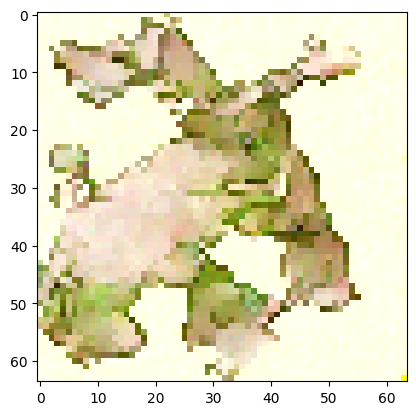

0.06445531:  55%|█████▍    | 10999/20001 [14:13<11:27, 13.10it/s]

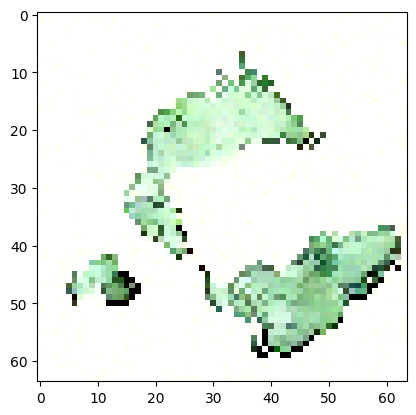

0.04677822:  57%|█████▋    | 11499/20001 [14:52<10:49, 13.10it/s]

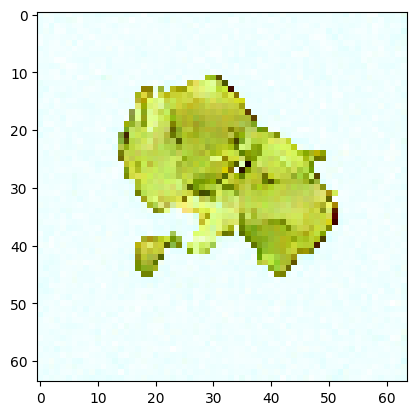

0.05899530:  60%|█████▉    | 11999/20001 [15:31<10:11, 13.09it/s]

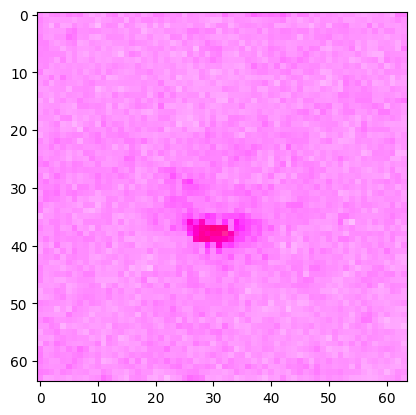

0.04715463:  62%|██████▏   | 12499/20001 [16:09<09:32, 13.10it/s]

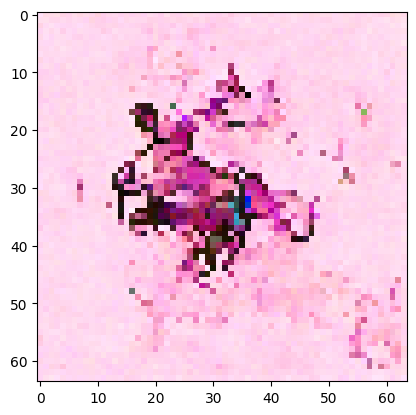

0.06316284:  65%|██████▍   | 12999/20001 [16:48<08:55, 13.08it/s]

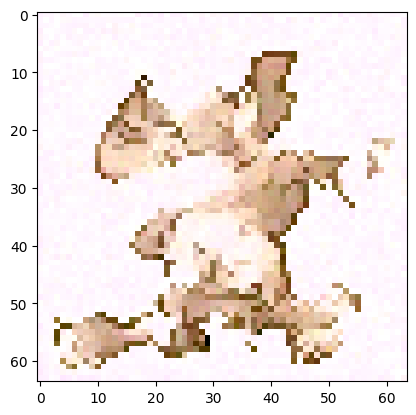

0.02455064:  67%|██████▋   | 13499/20001 [17:27<08:16, 13.10it/s]

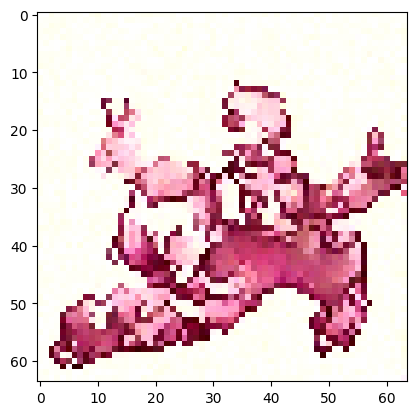

0.04194924:  70%|██████▉   | 13999/20001 [18:06<07:38, 13.08it/s]

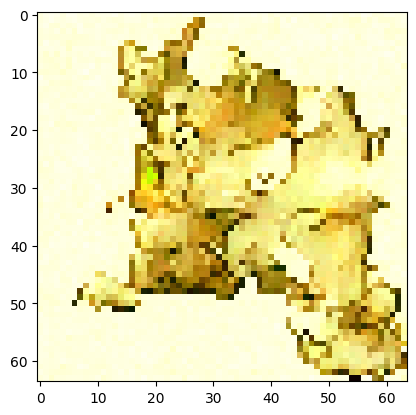

0.03362578:  72%|███████▏  | 14499/20001 [18:44<06:59, 13.11it/s]

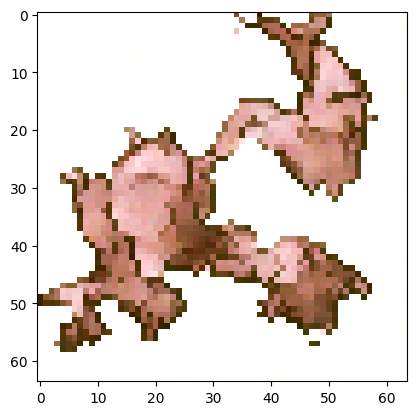

0.03227237:  75%|███████▍  | 14999/20001 [19:23<06:21, 13.12it/s]

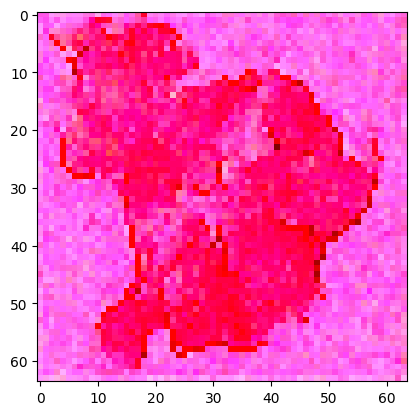

0.05933827:  77%|███████▋  | 15499/20001 [20:02<05:43, 13.10it/s]

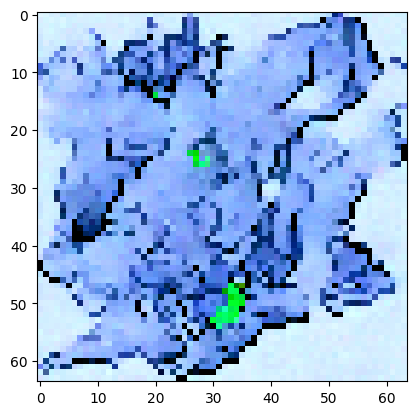

0.03106520:  80%|███████▉  | 15999/20001 [20:41<05:05, 13.08it/s]

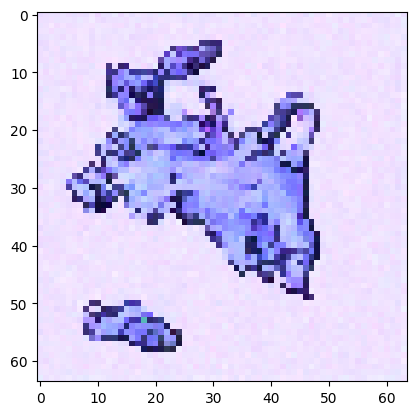

0.03155001:  82%|████████▏ | 16499/20001 [21:20<04:27, 13.12it/s]

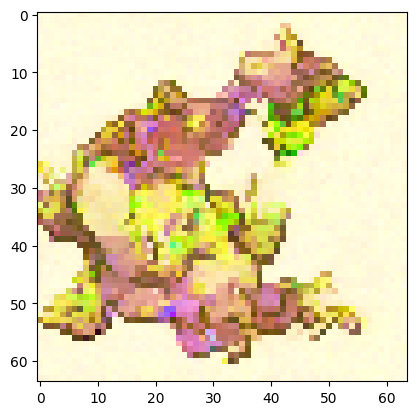

0.05690030:  85%|████████▍ | 16999/20001 [21:58<03:49, 13.11it/s]

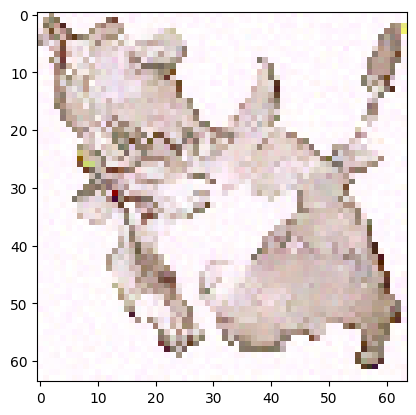

0.02077396:  87%|████████▋ | 17499/20001 [22:37<03:11, 13.10it/s]

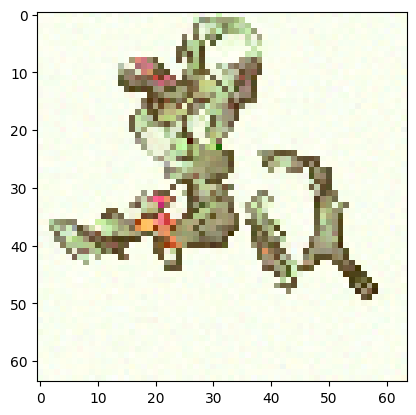

0.02021432:  90%|████████▉ | 17999/20001 [23:16<02:32, 13.10it/s]

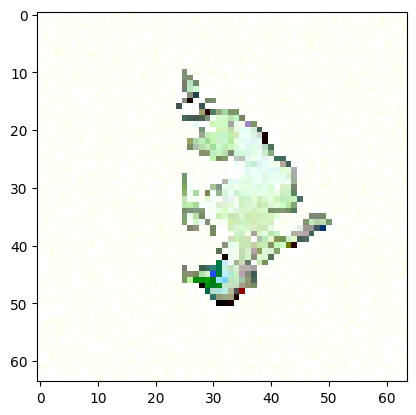

0.03931507:  92%|█████████▏| 18499/20001 [23:55<01:54, 13.10it/s]

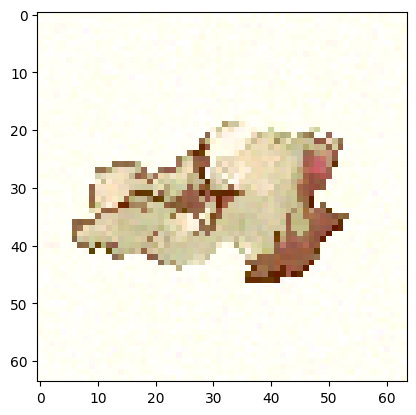

0.03310508:  95%|█████████▍| 18999/20001 [24:34<01:16, 13.11it/s]

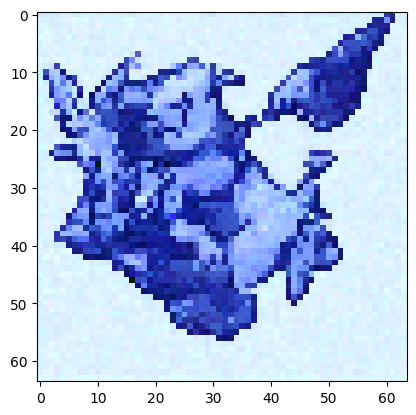

0.05693281:  97%|█████████▋| 19499/20001 [25:12<00:38, 13.12it/s]

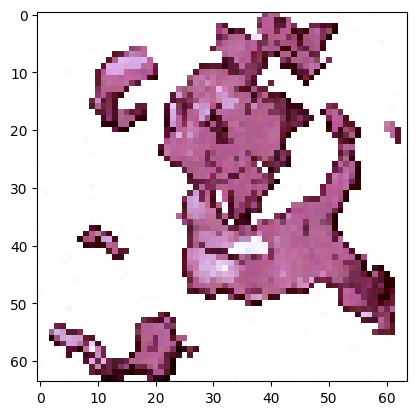

0.05570231: 100%|█████████▉| 19999/20001 [25:51<00:00, 13.09it/s]

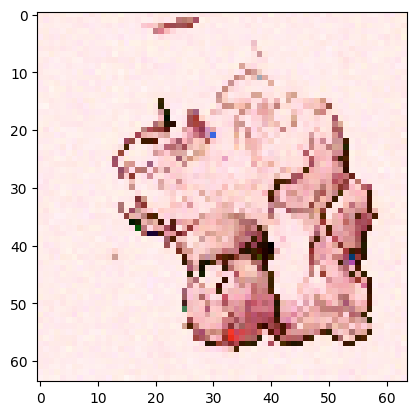

0.03960130: 100%|██████████| 20001/20001 [25:52<00:00, 12.88it/s]


In [6]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
pbar = tqdm(range(20001))#, miniters=15)
def closure():
    optimizer.zero_grad()

    bs = 8

    source = randint(0, 2)
    batch = torch.randperm(385)[:bs]
    x0 = pimages[source, batch]
    x0 = torch.stack([transform(x) for x in x0], dim=0)
    
    e = torch.randn(x0.shape, device=device)
    t = torch.randint(0, T - 1, (bs,), device=device)

    x_nois = torch.sqrt(alpha_[t])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[t])[:, None, None, None] * e
    #xc = contour[source, batch]
    #xn = torch.cat([x_nois, xc], dim=1)

    e_pred = model(x_nois, t)

    # Calculate the loss between the result and the noise
    loss = loss_func(e, e_pred)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss

model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 500 == 0:
        generate_image()

torch.save(model.state_dict(), 'model.pt')